In [ ]:
################################################################################
########################          Yelp Reviews          ######################## 
########################    Classification : Xgboost    ######################## 
########################  Stars on Reviews: 1 & 2 vs 5  ########################
################################################################################

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gensim==3.8.3
!pip install xgboost==1.5.2
!pip install optuna
import os
import random
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import multiprocessing
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import xgboost as xgb
from xgboost import XGBClassifier
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
import joblib
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

my_dpi=96

In [ ]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Sat May 14 10:52:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    34W / 250W |    607MiB / 16280MiB |      0%      Default |
|            

In [ ]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [ ]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1541486, 2)


,stars_reviews,cleanReview
index,,
2,5.0,"[wonderful, place, get, lunch, staff, friendly..."
3,5.0,"[dedicated, loving, memory, gary, feldman, gre..."
5,5.0,"[love, place, everything, menu, delicious, lik..."
7,5.0,"[truely, hidden, gem, place, greatest, buffalo..."
9,5.0,"[seriously, great, fresh, fantastic, food, spo..."


In [ ]:
# Process format of reviews for word2vec
df = df.copy()
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

,stars_reviews,cleanReview
index,,
2,5.0,"[""wonderful"", ""place"", ""get"", ""lunch"", ""staff""..."
3,5.0,"[""dedicated"", ""loving"", ""memory"", ""gary"", ""fel..."
5,5.0,"[""love"", ""place"", ""everything"", ""menu"", ""delic..."
7,5.0,"[""truely"", ""hidden"", ""gem"", ""place"", ""greatest..."
9,5.0,"[""seriously"", ""great"", ""fresh"", ""fantastic"", ""..."


In [ ]:
# Recode to binary
df = df.copy()
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

print('Number of reviews per group:')
df[['stars_reviews']].value_counts() 

Number of reviews per group:


stars_reviews
0.0              770743
1.0              770743
dtype: int64

In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
# Load model
word2vec_path = 'gensim_w2vModel_sentPosNeg_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
# Save embedded word vector space
wv = model.wv
print(len(wv.vocab),'unique words in the dataset.')

205415 unique words in the dataset.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [ ]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for review documents. 
    This is done in the transform function which is used to generate mean vectors in model pipelines.
    The class has both fit and transform functions so that it may be used in an sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        #If using GloVe the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        #Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Need to implement a fit method as required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        This function generates a w2v vector for a set of tokens. This is done by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
print('Pipeline for Word2Vec:')
pl  = Pipeline([("W2vVectorizer", W2vVectorizer(wv))])
pl

Pipeline for Word2Vec:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7f2a4b141290>)])

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_PKL


In [ ]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value
    )

    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  
    run_time = timer() - start

    return np.mean(cv_scores)       

In [ ]:
################################################################################
######################     Xgboost Optuna HPO   ################################
######################         100 trials       ################################
################################################################################
def xgb_hpo(trial):
    """
    Objective function to tune a `XgboostClassifier` model.
    """
    joblib.dump(study, 'Xgboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl')

    # Define parameter grid
    params_xgboost_optuna = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
    'max_depth': trial.suggest_int('max_depth', 3, 10),

    'subsample': trial.suggest_uniform('subsample', 0, 1),

    'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
    'reg_alpha' : trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
    'reg_lambda' : trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),

    'colsample_bytree' : trial.suggest_uniform('colsample_bytree', 0, 1),

    'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel', 0, 1), 

    'min_child_weight' : trial.suggest_int('min_child_weight', 0, 10),
    }



    model = XGBClassifier(
        objective='binary:logistic',
        n_jobs=-1,
        random_state=seed_value,
        booster='gbtree',  
        tree_method='gpu_hist', 
        scale_pos_weight=1,
        use_label_encoder=False,
        verbosity=0,
        **params_xgboost_optuna,
    )
    
    return train_model_for_study(features, label, model)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_PKL/

study = joblib.load('Xgboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_PKL
Number of finished trials: 58
Best trial: {'n_estimators': 350, 'max_depth': 10, 'subsample': 0.5784474494510279, 'gamma': 2.978730342504939e-07, 'learning_rate': 0.06758461236607097, 'reg_alpha': 0.01063148432854222, 'reg_lambda': 0.0045336809368611225, 'colsample_bytree': 0.8125790509917987, 'colsample_bylevel': 0.5589248585105144, 'min_child_weight': 5}
Lowest LogLoss 0.1568270356106955


In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
if os.path.isfile('Xgboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl'):
    study = joblib.load('Xgboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(xgb_hpo, n_trials=42)

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
[140]	validation_0-logloss:0.16178
[141]	validation_0-logloss:0.16170
[142]	validation_0-logloss:0.16166
[143]	validation_0-logloss:0.16158
[144]	validation_0-logloss:0.16150
[145]	validation_0-logloss:0.16142
[146]	validation_0-logloss:0.16136
[147]	validation_0-logloss:0.16131
[148]	validation_0-logloss:0.16124
[149]	validation_0-logloss:0.16117
[150]	validation_0-logloss:0.16110
[151]	validation_0-logloss:0.16105
[152]	validation_0-logloss:0.16101
[153]	validation_0-logloss:0.16093
[154]	validation_0-logloss:0.16090
[155]	validation_0-logloss:0.16084
[156]	validation_0-logloss:0.16079
[157]	validation_0-logloss:0.16071
[158]	validation_0-logloss:0.16067
[159]	validation_0-logloss:0.16060
[160]	validation_0-logloss:0.16057
[161]	validation_0-logloss:0.16051
[162]	validation_0-logloss:0.16048
[163]	validation_0-logloss:0.16042
[164]	validation_0-logloss:0.16037
[165]	validation_0-logloss:0.16033
[166]	validation_0-logloss:0.16028
[167

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/trialOptions/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'logloss'},inplace=True)
trials_df.rename(columns={'params_colsample_bylevel':'colsample_bylevel'}, inplace=True)
trials_df.rename(columns={'params_colsample_bytree':'colsample_bytree'}, inplace=True)
trials_df.rename(columns={'params_gamma':'gamma'}, inplace=True)
trials_df.rename(columns={'params_learning_rate':'learning_rate'}, inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_weight':'min_child_weight'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_reg_alpha':'reg_alpha'}, inplace=True)
trials_df.rename(columns={'params_reg_lambda':'reg_lambda'}, inplace=True)
trials_df.rename(columns={'params_subsample':'subsample'}, inplace=True)

trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Xgboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
73         73  0.156489 2022-05-14 04:06:04.406419 2022-05-14 04:10:16.250615   
86         86  0.156531 2022-05-14 05:01:34.406502 2022-05-14 05:05:45.751983   
87         87  0.156570 2022-05-14 05:05:45.752131 2022-05-14 05:10:00.817544   
92         92  0.156574 2022-05-14 05:26:50.178764 2022-05-14 05:30:56.313955   
74         74  0.156604 2022-05-14 04:10:16.250806 2022-05-14 04:14:27.038587   
..        ...       ...                        ...                        ...   
20         20  0.647016 2022-05-14 00:17:29.444596 2022-05-14 00:21:16.669263   
82         82  0.661269 2022-05-14 04:44:34.100424 2022-05-14 04:48:54.589385   
10         10  0.670271 2022-05-13 22:18:41.251282 2022-05-13 22:21:35.807780   
12         12       NaN 2022-05-13 22:24:19.416153                        NaT   
57         57       NaN 2022-05-14 02:41:06.974795                        NaT   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Xgboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Xgboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Xgboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_child_weight', 
                                                       'max_depth', 
                                                       'learning_rate', 
                                                       'gamma'])
py.plot(fig, filename='contour_Xgboost_Optuna_100_GPU_w2vSentPol.html')
fig.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/trialOptions/

# Access results
trials_df = pd.read_csv('Xgboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/trialOptions


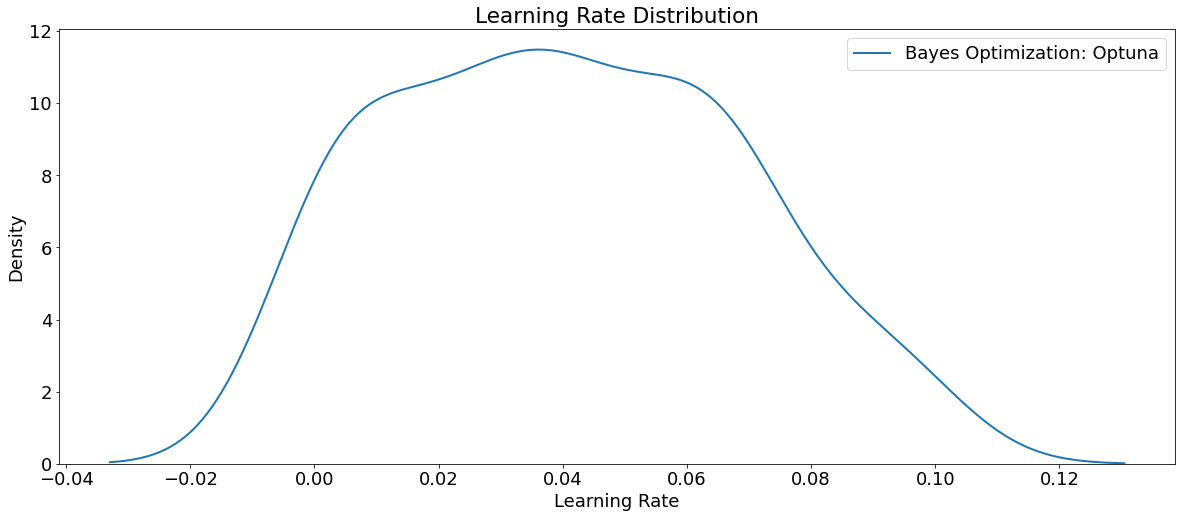

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label = 'Bayes Optimization: Optuna', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

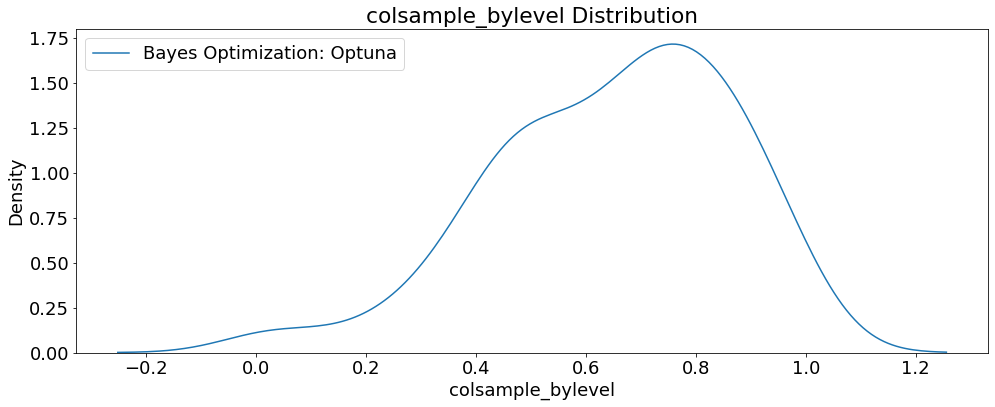

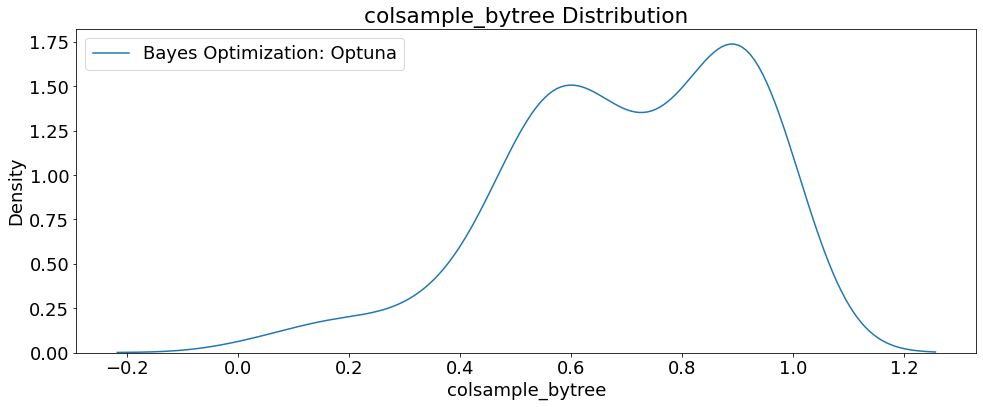

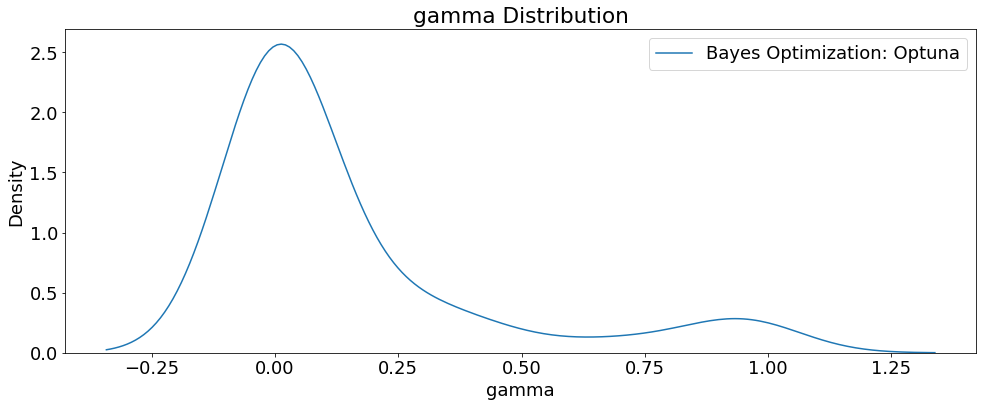

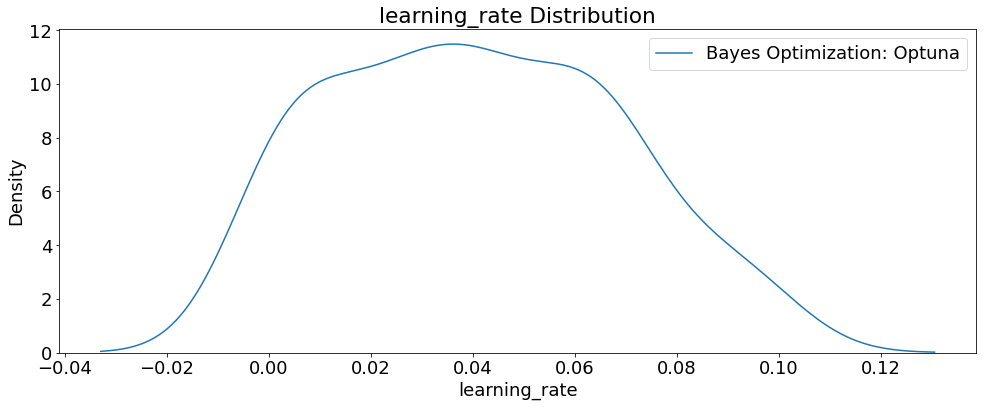

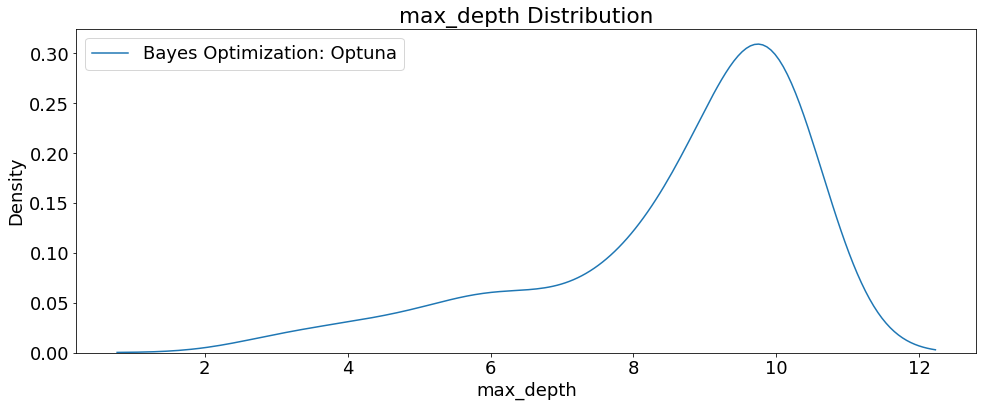

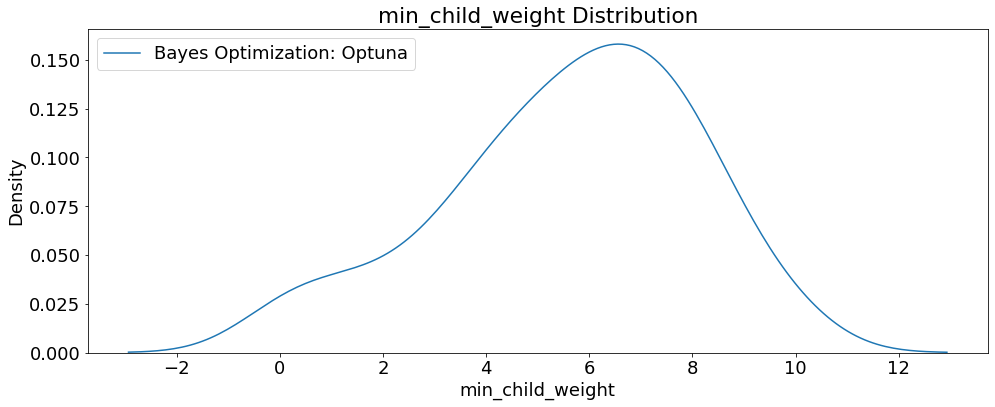

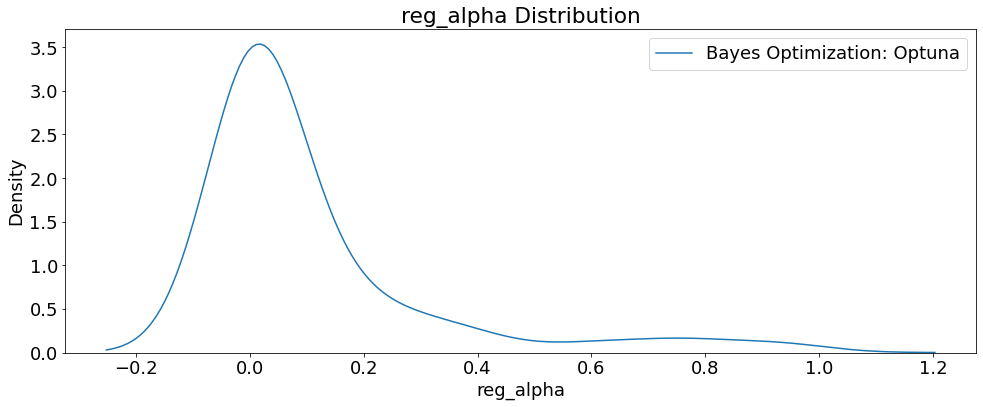

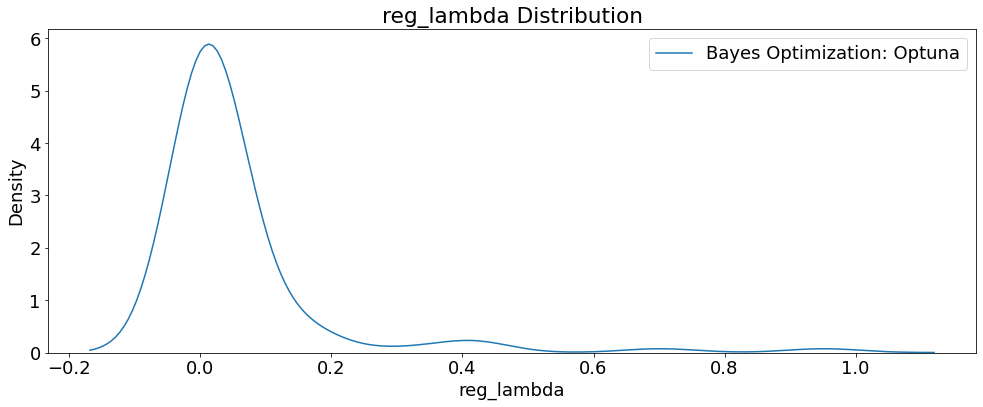

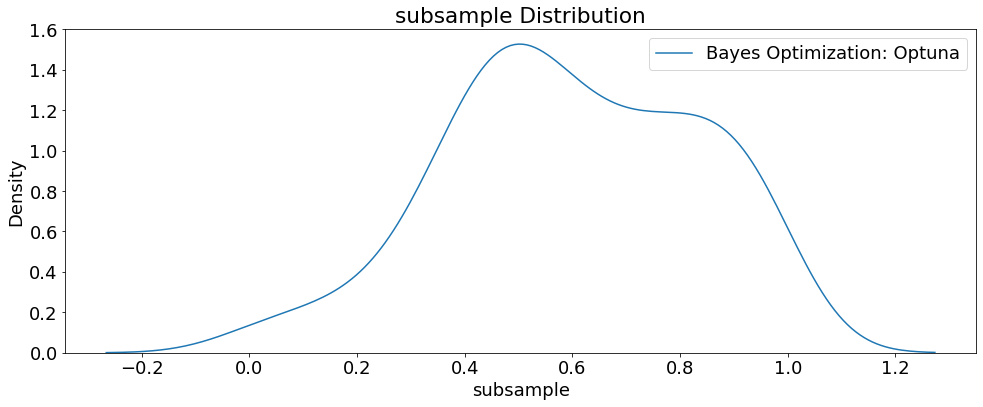

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning

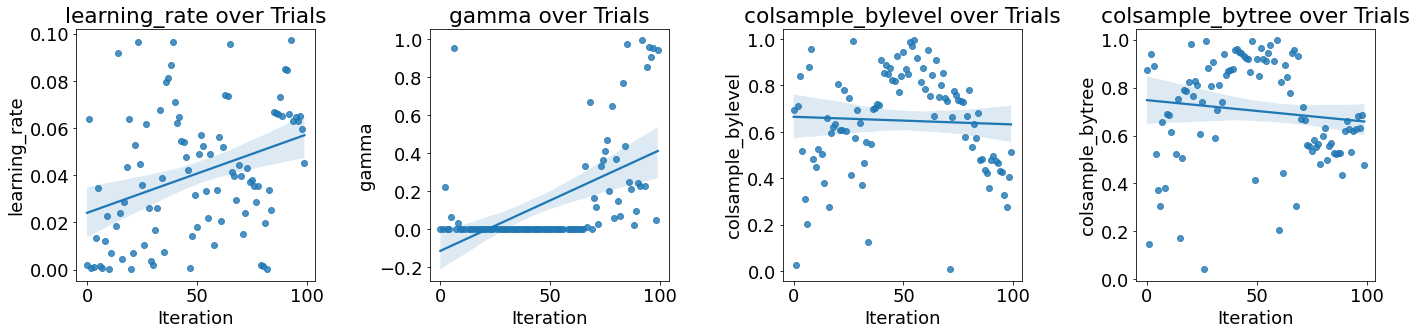

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['learning_rate', 'gamma', 'colsample_bylevel',
                         'colsample_bytree']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



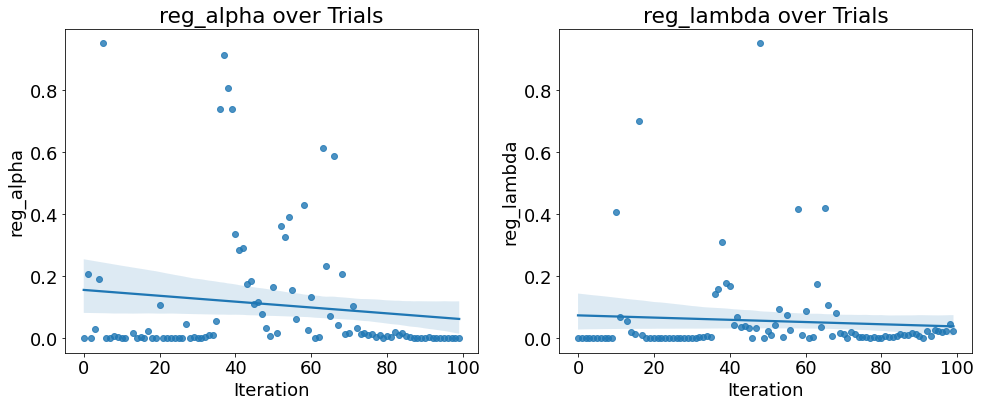

In [ ]:
# Scatterplot of regularization hyperparameters
fig, axs = plt.subplots(1, 2, figsize = (14, 6))
i = 0
for i, hpo in enumerate(['reg_alpha', 'reg_lambda']):
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_Explanations


In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Xgboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Xgboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'colsample_bylevel': 0.7754415566007444,
 'colsample_bytree': 0.5618506319600263,
 'gamma': 0.33389373119504034,
 'learning_rate': 0.0429674643909927,
 'loss_function': 'Logloss',
 'max_depth': 10,
 'min_child_weight': 6,
 'n_estimators': 470,
 'random_state': 42,
 'reg_alpha': 0.01181211242876595,
 'reg_lambda': 0.013133596584266561,
 'subsample': 0.6311353577683386}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_PKL/


study = joblib.load('Xgboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.pkl')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/Model_PKL


In [ ]:
label = df[['stars_reviews']]

features = df.cleanReview

In [ ]:
# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [67]:
# Re-create the best model and train on the training data
best_model = xgb.XGBClassifier(objective='binary:logistic',
                                                booster='gbtree',
                                                tree_method='gpu_hist', 
                                                scale_pos_weight=1,
                                                use_label_encoder=False,
                                                verbosity=0,
                                                n_jobs=-1, 
                                                **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Xgboost_HPO_Optuna_trials100_GPU_balancedSizeSentiment_w2vSentPol.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Xgboost_HPO_Optuna_trials100_GPU_balancedSizeSentiment_w2vSentPol.pkl')
# print(model)
# =============================================================================

In [68]:
print('Results from Xgboost HPO Optuna 100 GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')

print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Xgboost HPO Optuna 100 GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95    616594
         1.0       0.95      0.95      0.95    616594

    accuracy                           0.95   1233188
   macro avg       0.95      0.95      0.95   1233188
weighted avg       0.95      0.95      0.95   1233188



Confusion matrix: Train
[[587452  29142]
 [ 29328 587266]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94    154149
         1.0       0.94      0.94      0.94    154149

    accuracy                           0.94    308298
   macro avg       0.94      0.94      0.94    308298
weighted avg       0.94      0.94      0.94    308298



Confusion matrix: Test
[[144782   9367]
 [  9460 144689]]


Accuracy score: train: 0.953, test: 0.939
Precision score: train: 0.953, test: 0.939
Recall score: train: 0.952, t

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Xgboost/ReviewStars/trialOptions/

# Access results
trials_df = pd.read_csv('Xgboost_Optuna_100_GPU_balancedSizeSentiment_w2vSentPol.csv')

In [71]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93893 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    73
logloss                                0.156489
datetime_start       2022-05-14 04:06:04.406419
datetime_complete    2022-05-14 04:10:16.250615
duration                 0 days 00:04:11.844196
colsample_bylevel                      0.775442
colsample_bytree                       0.561851
gamma                                  0.333894
learning_rate                          0.042967
max_depth                                  10.0
min_child_weight                            6.0
n_estimators                              470.0
reg_alpha                              0.011812
reg_lambda                             0.013134
subsample                              0.631135
state                                  COMPLETE
Name: 0, dtype: object
